<h1 style="text-align: center;">Trabalho Computacional - Otimização - 2022.2</p>

**Universidade Federal do Rio de Janeiro - PESC**  
**Professores:** Laura Bahiense e Luidi Simonetti  
**Alunos:** Leonardo Nunes Guimarães Costa e Victor Ribeiro 

## 1 - Objetivo e Especificações


Minimizar computacionalmente a seguinte função:

\begin{equation*}
    f(x_1, x_2) = \sqrt{ln^2(x_1)+ln^2(x_2)} \qquad 
\end{equation*}

### 1.1 - Bibliotecas usadas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from tabulate import tabulate
from random import randint
from operator import add

### 1.2 - Funções Necessárias


#### Calculo da Função em um Ponto

In [2]:
def funcValue(x1, x2):
        return np.sqrt(np.log(x1)**2 + np.log(x2)**2)

#### Calculo do Gradiente em um Ponto


In [3]:
def gradValue(x1,x2):
    denom = funcValue(x1,x2)
    return np.log(x1)/(denom*x1), np.log(x2)/(denom*x2)

#### Calculo da Hessiana em um Ponto


In [4]:
def hessianValue(x1,x2):
    if(x1 <= 0 or x2 <= 0 ): return (np.inf)*3
    log1, log2 = np.log(x1), np.log(x2)
    func, func3 = funcValue(x1,x2), (log1**2 + log2**2)**(1.5)
    a1 = (1/x1**2)*(((1-log1)/(func))-(log1**2/func3))
    a2 = (1/x2**2)*(((1-log2)/(func))-(log2**2/func3))
    b = (-1)*(log1*log2)/(x1*x2*func3)
    return [[a1, b],[b,a2]]

#### Calculo dos Autovalores de uma Matriz

In [5]:
def eigenValues(matrix):
    hdelta, avg = np.sqrt((matrix[0][0]-matrix[1][1])**2 + matrix[0][1]**2)/2, (matrix[0][0] + matrix[1][1])/2
    ev1 = avg + hdelta
    ev2 = avg - hdelta
    return ev1, ev2

#### Checar Convexidade a Partir da Definição da Matriz

In [6]:
def checkConvexity(ev1,ev2):
    if (ev1 > 0 and ev2 > 0): return 1
    elif (ev1 < 0 and ev2 < 0): return -1
    else: return False

#### Iteração do BFGS

In [7]:
def bfgs(H, p, q):
    p_t = np.transpose(p)
    q_t = np.transpose(q)
    denominator = np.dot(p_t, q)
    if denominator:
        term_1 = (1+((np.linalg.multi_dot([q_t, H, q]))/denominator))
        term_2 = (np.dot(p, p_t))/denominator
        term_3 = ((np.dot(np.dot(p, q_t), H))+(np.dot(np.dot(H, q), p)))/denominator
        return H + (term_1*term_2) - term_3
    else: return H
    

#### Direção de um Vetor

In [8]:
def direction(x,y):
    denom = np.sqrt(x**2 + y**2)
    return [x/denom , y/denom]
    

#### Trunco de Float do Python

In [9]:
def truncate(extensive, decimalSize):
    pointer = 0.1**decimalSize
    reduced = (extensive//pointer)*pointer
    residue = extensive - reduced
    return reduced, residue

#### Geração de Tabela comSimulações

In [10]:
def simulate(startingPointList, method, header):
    finalList = []
    pointPaths = []
    for point in startingPointList:
        lineOutput = method(point)
        pointPaths += [lineOutput['pointsStored']]
        finalList += [[lineOutput['startingPoint'][0],lineOutput['startingPoint'][1],lineOutput['iterations'],lineOutput['stepSizeCalls'],lineOutput['currentPoint'][0],lineOutput['currentPoint'][1],lineOutput['currentValue'],lineOutput['residual']]]
    finalTable = tabulate(finalList, headers=["X°(x1)","X°(x2)", "#Iteracoes", "#Cham.Armijo", "X*(x1)","X*(x2)", "f(X*)", "Erro de Aproximacao"],floatfmt=[".4f",".4f","","",".6f",".6f",".6f"],tablefmt="fancy_outline")
    print('\n',header,'\n')
    print(finalTable)
    return pointPaths

#### Geração de Pontos

In [11]:
def getPoint():
    return 1.0/randint(1,10) + 1.0*randint(0,10), 1.0/randint(1,10) + 1.0*randint(0,10)# 82,6% Planalto | 16,8% Paredes | 0,6% Canto

def getCANTO():
    return 1.0/randint(1,100), 1.0/randint(1,100)

def getPAREDE1():
    return 1.0*randint(1,100), 1.0/randint(1,100)

def getPAREDE2():
    return 1.0/randint(1,100), 1.0*randint(1,100)

def getPLANALTO():
    return 1.0*randint(1,500),1.0*randint(1,500) 

### 1.3 - Métodos para construir gráficos da função

#### Gráfico da Fução

In [12]:
def plotFunction(x1, x2):
    '''Dados os intervalos de x1 e x2, retorna os gráficos e curva de nível da função nesse intervalo.'''
    fig = plt.figure(figsize=(24,8))
    color = 'inferno'

    # First subplot
    ax = fig.add_subplot(1, 3, 1, projection='3d')

    X1 = np.linspace(x1[0], x1[1])
    X2 = np.linspace(x2[0], x2[1])
    X1, X2 = np.meshgrid(X1, X2)
    Z = funcValue(X1, X2)
    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                    cmap=color, edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f')
    ax.view_init(25, 35)

    # Second subplot
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                    cmap=color, edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f')
    ax.view_init(15, 205)


    # Third subplot - Contour line
    ax = fig.add_subplot(1, 3, 3)
    h = ax.contourf(X1, X2, Z, cmap=color)
    plt.axis('scaled')
    fig.colorbar(h, shrink=0.7)
    
    plt.show()

#### Caminho de Pontos das Iterações

In [13]:
def plotPath(points):
    '''Função para ilustrar uma curva de nível com os pontos que foram obtidos
    durante a execução do método de otimização.\n
    Entrada:
        points: Array de tuplas, onde cada tupla representa um ponto (x1, x2).'''

    x = [item[0] for item in points]
    y = [item[1] for item in points]

    max_x, max_y = max(x)+1, max(y)+1
    min_x, min_y = max(min(x)-0.5, 0.0001), max(min(y)-0.5, 0.0001)

    plt.figure()
    plt.title('Ótimo em: '+str(points[-1])+f'\n Em {len(points)} iterações.')
    X1 = np.linspace(min_x, max_x)
    X2 = np.linspace(min_y, max_y)
    X1, X2 = np.meshgrid(X1, X2)
    Z = funcValue(X1, X2)
    plt.contourf(X1,X2,Z,cmap='inferno')
    plt.colorbar()
    plt.plot(x, y,'^-w')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.show()

##  2 - Estudo da Função

\begin{equation*}
    f(x_1, x_2) = \sqrt{ln^2(x_1)+ln^2(x_2)} \qquad \Omega = R^2
\end{equation*}

###  2.1 - Regiões e Pontos Críticos

É possível determinar o domínio natural da função como o primeiro quadrante sem valores nulos:

\begin{equation*}
    \Omega = x_1, x_2 > 0
\end{equation*}

Como $x_1$ e $x_2$ apresentam o mesmo comportamento, portanto a função é simétrica para o plano $x_1 = x_2$.

##### Uma Aproximação Grosseira 

Já que $ln(1) = 0$, é possível observar que $f(x_k,0) = |ln(x_k)|$ o que permite dividir a função em 4 regiões de 3 tipos diferentes:

Para ($ 0 < x_1 < 1$ e $x_2 > 1$) ou ($ 0 < x_2 < 1$ e $x_1 >1$) são as "paredes" da função em que valores próximos dos planos $x_1 = 0$ ou $x_2 = 0$ divergem e de forma oposta ao se aproximar dos planos $x_1 = 1$ ou $x_2 = 1$ a função se aproxima de $ln(x_1)$ ou $ln(x_2)$ dependendo da parede em questão.

Para $ 0 < x_1,x_2 < 1$, é o "canto" da função onde as paredes se unem e seu comportamento é similar ao destas, divergindo na direção da origem e zerando na direção do ponto $(1,1)$.


Como ultimo tipo na região $ x_1,x_2 > 1$ existe o "planalto" que monotonamente diverge para $x_1$ ou $x_2$ crescentes.

##### Aprofundando

Para encontrar os pontos críticos, vamos calcular o gradiente da função.

\begin{equation*}
  \nabla f(x_1, x_2) = \left( \frac{\partial{f(x_1, x_2)}}{\partial{x_1}}, \frac{\partial{f(x_1, x_2)}}{\partial{x_2}} \right)
\end{equation*}

\begin{equation*}
  \nabla f(x_1, x_2) = \left( \frac{\ln(x_1)}{x_1\sqrt{\ln^2(x_1)+\ln^2(x_2)}}, \frac{\ln(x_2)}{x_2\sqrt{\ln^2(x_1)+\ln^2(x_2)}} \right)
\end{equation*}

Para o ponto crítico, devemos encontrar os valores de $ (x_1, x_2) $ em que o numerador seja igual a 0.

\begin{equation*}
    ( \ln(x_1), \ln(x_2) ) = (0,0) \qquad \Rightarrow \qquad (x_1, x_2) = (1,1)
\end{equation*}

Porém os denominadores também são 0 neste ponto, o que caracteriza uma indeterminação e verificando melhor o ponto (1,1) possui uma descontinuidade (de pulo) no gradiente. Não sendo um ponto estacionário e sim um "bico"( descontinuidade de salto) exatamente onde as 4 regiões descritas anteriormente se juntam.

### 2.2 - Convexidade das Regiões

Podemos testar a convexidade das regiões supracitadas uma a uma e a melhor ferramenta para tal é calcular a matriz hessiana da função e verificar nas regiões:

\begin{equation*}
  \nabla² f(x_1, x_2) = 
\end{equation*}

\begin{bmatrix} \frac{1 - ln(x_1)}{x_1² \sqrt{ln²(x_1)+ln²(x_2)}} - \frac{ln²(x_1)}{x_1²(ln²(x_1)+ln²(x_2))^{3/2}} & - \frac{ln(x_1)ln(x_2)}{x_1 x_2(ln²(x_1)+ln²(x_2))^{3/2}}  \\ - \frac{ln(x_1)ln(x_2)}{x_1 x_2(ln²(x_1)+ln²(x_2))^{3/2}} & \frac{1 - ln(x_2)}{x_2² \sqrt{ln²(x_1)+ln²(x_2)}} - \frac{ln²(x_2)}{x_2²(ln²(x_1)+ln²(x_2))^{3/2}} \end{bmatrix}



###

### 2.3 - Visualização da Função

#### A Região do Canto:

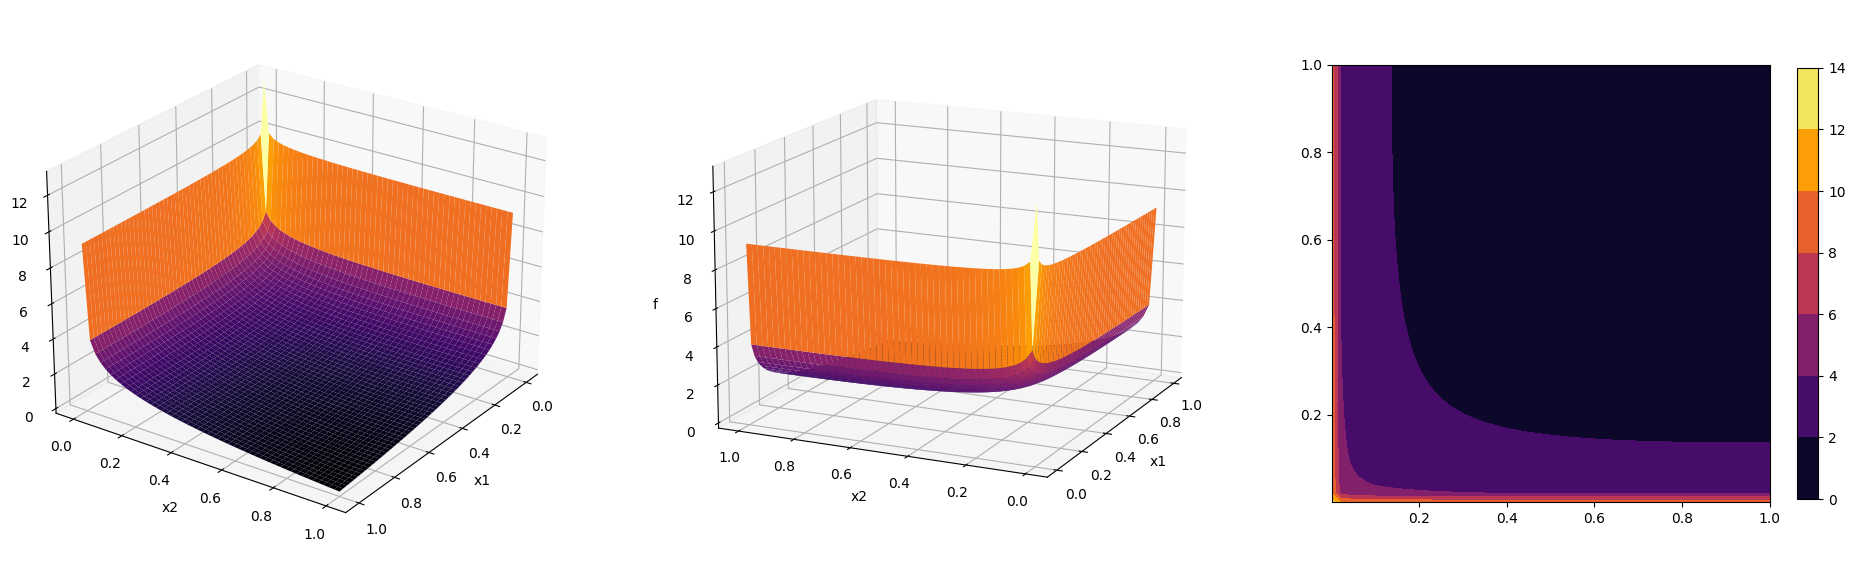

In [14]:
plotFunction(x1=[0.0001, 1.0], x2=[0.0001, 1.0])

#### A Parede ao Longo de $x_1$

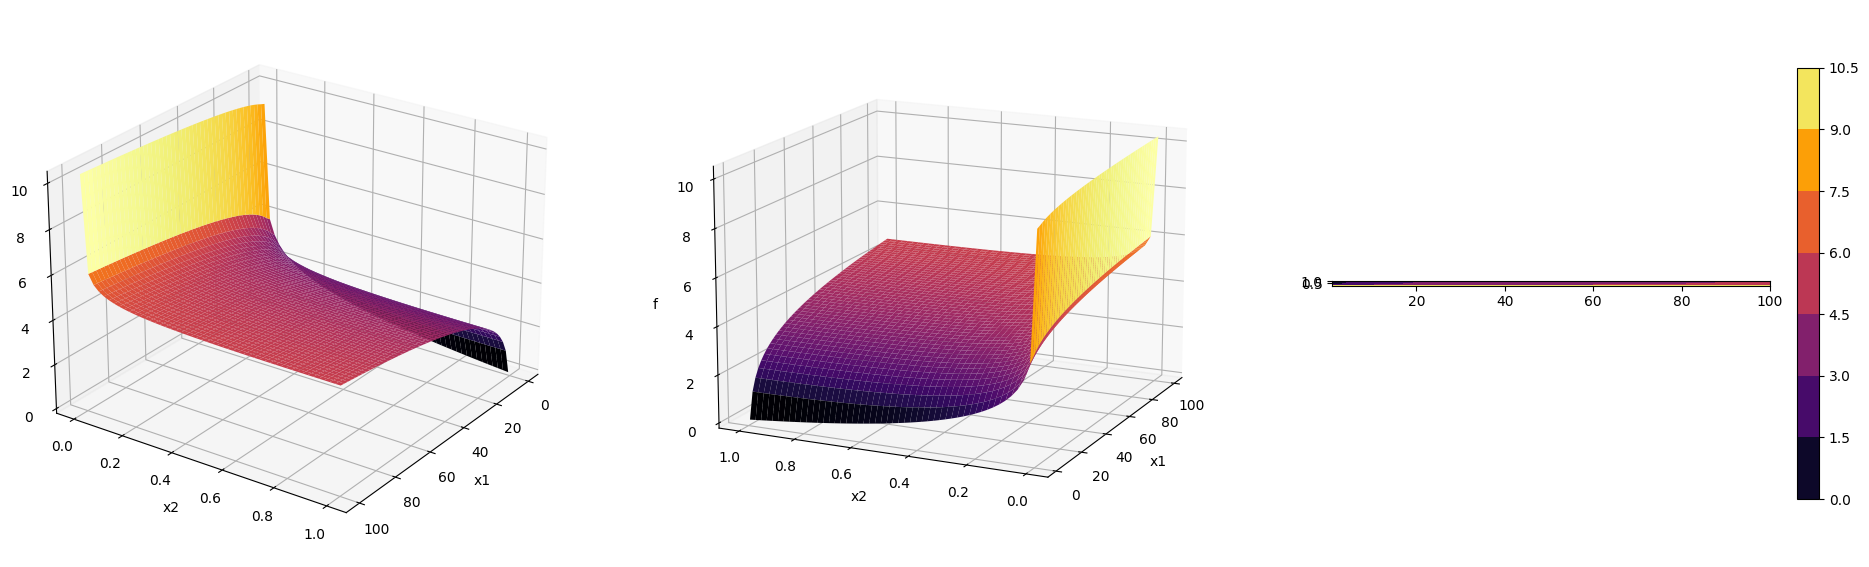

In [15]:
plotFunction(x1=[1.0, 100.0], x2=[0.0001, 1.0])

#### A Região do Planalto

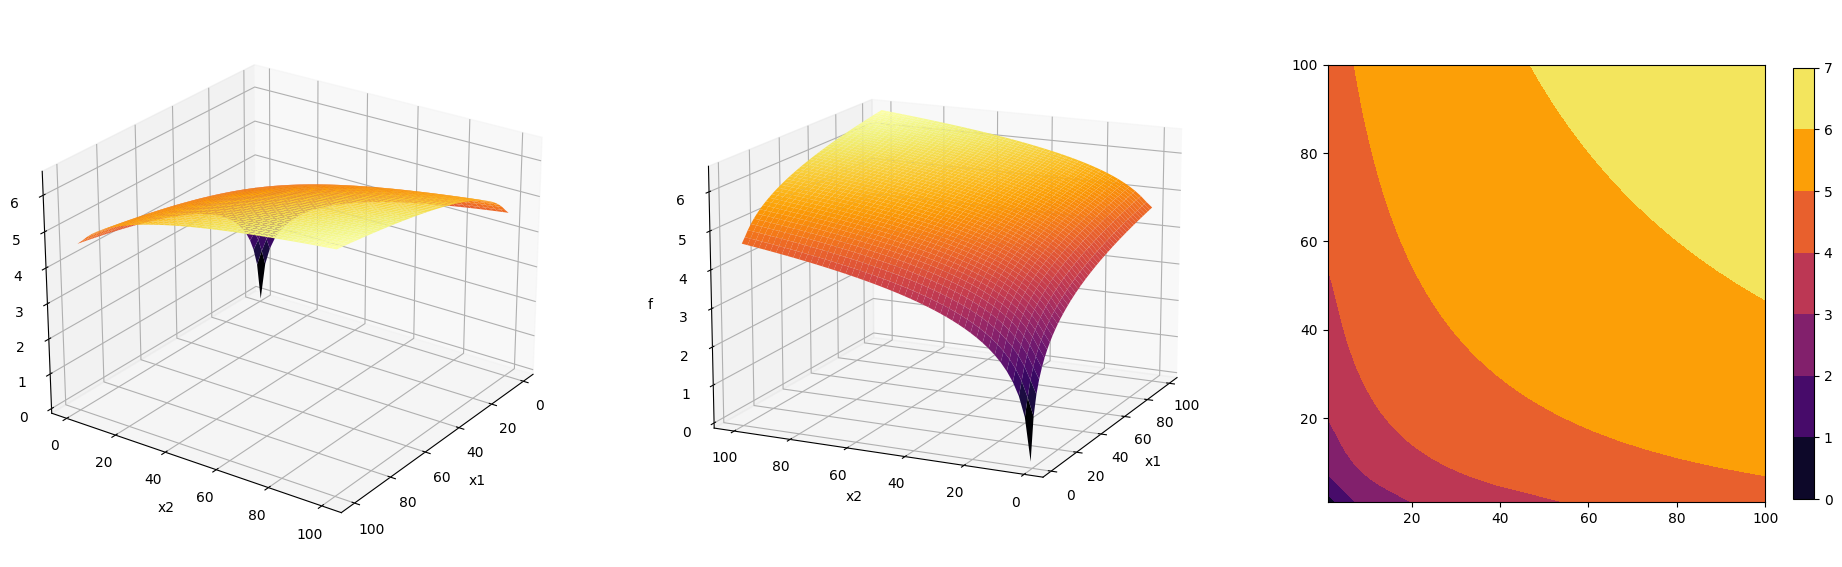

In [16]:
plotFunction(x1=[1.0, 100.0], x2=[1.0, 100.0])

Para compreender melhor o comportamento da função, foram utilizados os gráficos e curvas de nível abaixo, incluindo trechos das 4 regiões.

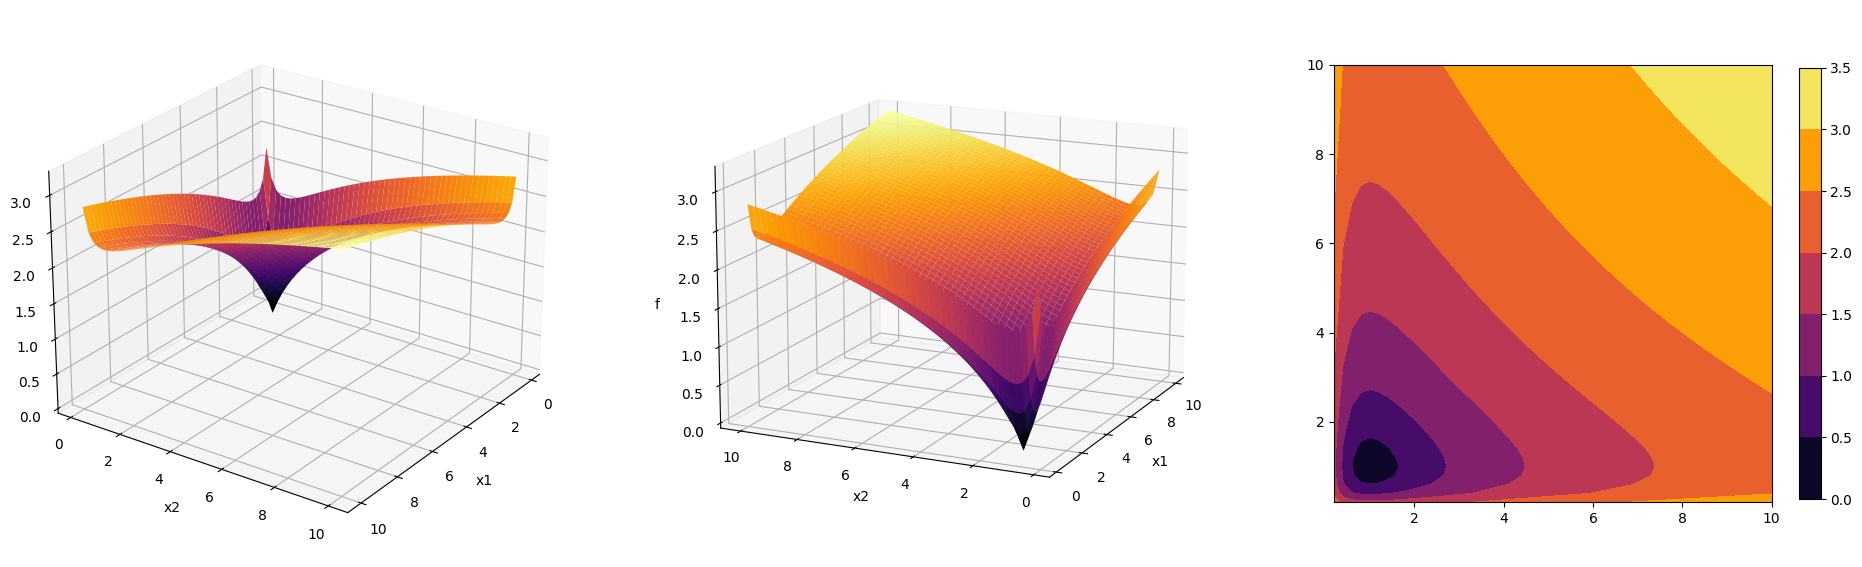

In [17]:
plotFunction(x1=[0.2, 10], x2=[0.2, 10])

Aproximando do bico em $(1,1)$

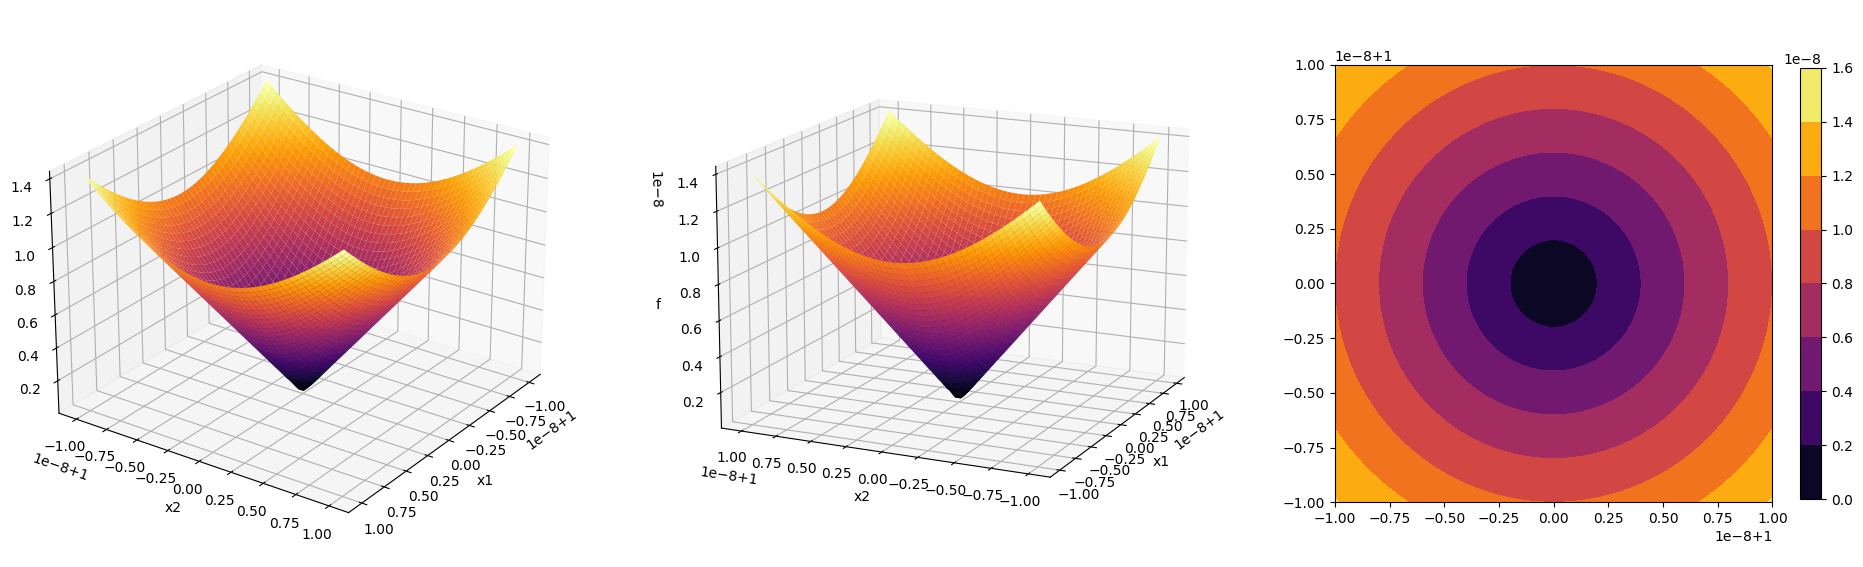

In [18]:
plotFunction(x1=[0.99999999, 1.00000001], x2=[0.99999999, 1.00000001])

## 3 - Implementação dos Métodos


### 3.1 - Tamanho de Passo pela Regra de Armijo

Tendo a direção de decrescimento e três parâmetros numéricos $S > 0$ e 0 < $\beta, \sigma < 1$ e também considerado um limite para as iterações:

In [19]:
def stepSize(state,direction, S , beta , sigma ,m = 0, iterationCap = 100):
    iterationRem = iterationCap - 1
    if iterationRem < 1:
        return stepSize(state,direction,np.sqrt(S),beta,sigma**2)
    state['stepSizeCalls'] += 1
    stepLength = sigma*(beta**m)*S
    newPoint = list(map(add,list(state['currentPoint']),[i * stepLength for i in list(direction)]))
    if(newPoint[0] > 0 and newPoint[1] > 0): 
        newValue = funcValue(newPoint[0],newPoint[1]) 
    else: newValue = np.inf
    
    if(state['currentValue'] < newValue):
        m += 1
        return stepSize(state, direction, S, beta, sigma, m, iterationRem)
    else:
        state['currentPoint'] = (newPoint[0],newPoint[1])
        state['currentValue'] = newValue
        return state, stepLength

### 3.2 - Método do Gradiente

In [20]:
def gradientMethod(startingPoint, iteractionCap = 10000, epsolon = .000001, S = 2.34, beta = .45, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        grdientValue = gradValue(point[0],point[1])
        descendValue = [i *(-1) for i in grdientValue]
        descendDirection = direction(descendValue[0],descendValue[1])
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        if state['iterations'] > iteractionCap: 
            searching = False 
        valueDiff = startingValue - state['currentValue']
        if ( valueDiff < epsolon and stepDiff < epsolon ): 
            searching = False   
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

 ### 3.3.a - Método de Newton ( Com Problemas de Convergência)

In [21]:
def newtonMethodBroken(startingPoint, iteractionCap = 10000, epsolon = 0.00000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        descendDirection = direction(descendValue[0],descendValue[1])
        #print(point, "       ",descendDirection)
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

 ### 3.3.b - Método de Newton ( Ajustado)

In [22]:
def newtonMethod(startingPoint, iteractionCap = 10000, epsolon = 0.00000000000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        startingValue = state['currentValue']
        state['pointsStored'].append(point)
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        evs = eigenValues(hessian)
        convexity = checkConvexity(evs[0],evs[1])
        if (convexity):
            inverted = np.linalg.inv(hessian)*convexity*(-1)
            descendValue = np.dot(inverted, gradientValue)
        else:
            inverted = [[-1,0],[0,-1]]
            descendValue = np.dot(inverted, gradientValue)
        
        descendDirection = direction(descendValue[0],descendValue[1])
        #print(point, "       ",descendDirection)
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state

### 3.4.a - Método BFGS (Com Problemas de Convergência)

In [23]:
def quasiNewtonMethodBroken(startingPoint, iteractionCap = 10000, epsolon = 0.00000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 
    'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 
    'residual': 0, 'pointsStored': []}   
    searching = True
    stepDiff = S
    H = np.array([[1,0], [0,1]])
    while(searching):
        state['iterations'] += 1
        
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        directionVector = -1*(np.dot(H, gradientValue))
        descendDirection = direction(directionVector[0], directionVector[1])
        #print(point, "       ",descendDirection)
        
        lastPoint = state['currentPoint']
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        point = state['currentPoint']
        lastGradient = gradientValue
        gradientValue = gradValue(point[0],point[1])

        p = np.subtract(point, lastPoint)
        q = np.subtract(gradientValue, lastGradient)

        H = bfgs(H, p, q)

        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


### 3.4.b - Método BFGS (Ajustado)

In [24]:
def quasiNewtonMethod(startingPoint, iteractionCap = 10000, epsolon = 0.00000000000001, S = 1.15, beta = .1, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 
    'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 
    'residual': 0, 'pointsStored': []}   
    searching = True
    stepDiff = S
    gradientValue = (1,1)
    H = np.array([[1,0], [0,1]])
    while(searching):
        state['iterations'] += 1
        
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        lastGradient = gradientValue
        gradientValue = gradValue(point[0],point[1])
        hessian = hessianValue(point[0],point[1])
        lastPoint = state['currentPoint']
        evs = eigenValues(hessian)
        convexity = checkConvexity(evs[0],evs[1])
        if (convexity):
            p = np.subtract(point, lastPoint)
            q = np.subtract(gradientValue, lastGradient)
            
            H = bfgs(H, p, q)
        else:
            H = [[1,0],[0,1]]
        
        inverted = np.linalg.inv(hessian)
        descendValue = np.dot(inverted, gradientValue)
        directionVector = -1*(np.dot(H, gradientValue))
        descendDirection = direction(directionVector[0], directionVector[1])
        #print(point, "       ",descendDirection)
        
        
        state, stepDiff = stepSize(state, descendDirection,stepDiff * 10, beta, sigma)
        point = state['currentPoint']
        


        #print(point) - #pra ver o ponto se aproximar do otimo
        if state['iterations'] > iteractionCap: 
            searching = False 
            print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        #print(valueDiff,stepDiff)
        if ( valueDiff < epsolon and stepDiff < epsolon ):
            #print("=====")
            #print(valueDiff,stepDiff) 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


### 3.5 - Método das 4 Direções (extra, brincadeira com o passo de Armijo)

In [25]:
def mockMethod2(startingPoint, iteractionCap = 10000, epsolon = .000001, S = 1.3, beta = .4, sigma = .1):
    state = {'startingPoint': startingPoint, 'iterations': 0, 'stepSizeCalls': 0, 'currentPoint': startingPoint, 'currentValue': funcValue(startingPoint[0],startingPoint[1]), 'residual': 0, 'pointsStored': []}
    searching = True
    stepDiff = S
    while(searching):
        state['iterations'] += 1
        point = state['currentPoint']
        state['pointsStored'].append(point)
        startingValue = state['currentValue']
        westStep, eastStep, northStep, southStep = state, state, state, state
        west, east, north, south = [-1,0], [1,0], [0,1], [0,-1]
        westStep = stepSize(westStep, west,stepDiff * 10, beta, sigma)
        eastStep = stepSize(eastStep, east,stepDiff * 10, beta, sigma)
        northStep = stepSize(northStep, north,stepDiff * 10, beta, sigma)
        southStep = stepSize(southStep, south,stepDiff * 10, beta, sigma)
        
        #problema: todos os passos estão retornando o mesmo resultado:(  
        larger = ({},0)
        
        for step in [westStep, eastStep, northStep, southStep]:
            if step[1] > larger[1]: larger = step
        
        state, stepDiff = larger[0],larger[1]
        if state['iterations'] > iteractionCap: 
            searching = False 
            #print('iteration limit')
        valueDiff = startingValue - state['currentValue']
        if ( valueDiff < epsolon and stepDiff < epsolon ): 
            searching = False
            #print("optimal")
    
    splitValue = truncate(state['currentValue'],6)
    state['currentValue'] = splitValue[0]
    state['residual'] = splitValue[1]
    return state


## 4 - Resultados

Gerando Pontos aleatórios nas 4 regiões:

In [26]:
canto, parede1, parede2, planalto, randomPoint = getCANTO(), getPAREDE1(), getPAREDE2(), getPLANALTO(), getPoint()

print(canto)
print(parede1)
print(parede2)
print(planalto)
print(randomPoint)

(0.01020408163265306, 0.034482758620689655)
(34.0, 0.011627906976744186)
(0.015151515151515152, 97.0)
(263.0, 298.0)
(7.0, 5.166666666666667)


### 4.1 - Simulção dos Métodos Ajustados

#### Gradiente


 TABELA 1

MÉTODO GRADIENTE 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0102 │   0.0345 │           13 │             32 │ 1.000000 │ 1.000000 │ 0.000000 │           4.28372e-08 │
│  34.0000 │   0.0116 │          107 │            126 │ 1.000000 │ 1.000000 │ 0.000000 │           5.25555e-08 │
│   0.0152 │  97.0000 │          646 │            667 │ 1.000000 │ 1.000000 │ 0.000000 │           5.98279e-10 │
│ 263.0000 │ 298.0000 │         1044 │           1063 │ 1.000000 │ 1.000000 │ 0.000000 │           6.57217e-09 │
│   7.0000 │   5.1667 │           12 │             34 │ 1.000000 │ 1.000000 │ 0.000000 │           2.72118e-09 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════

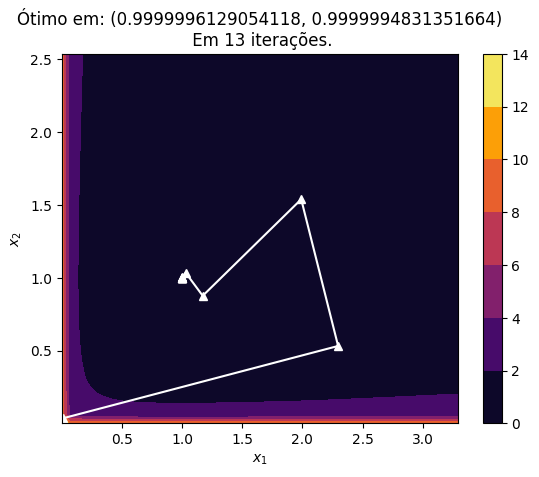

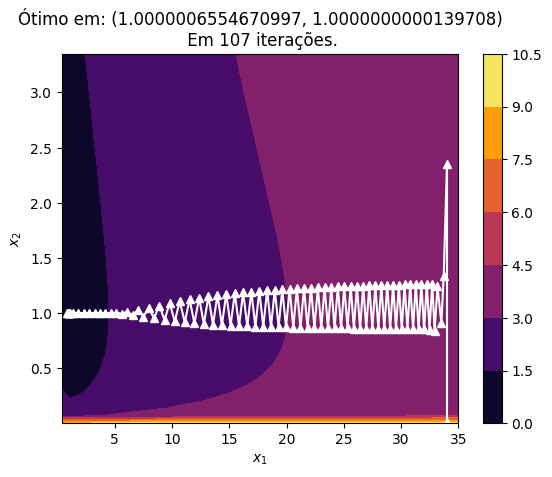

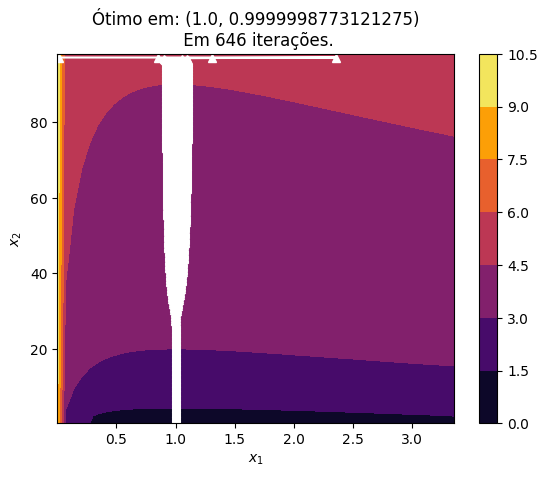

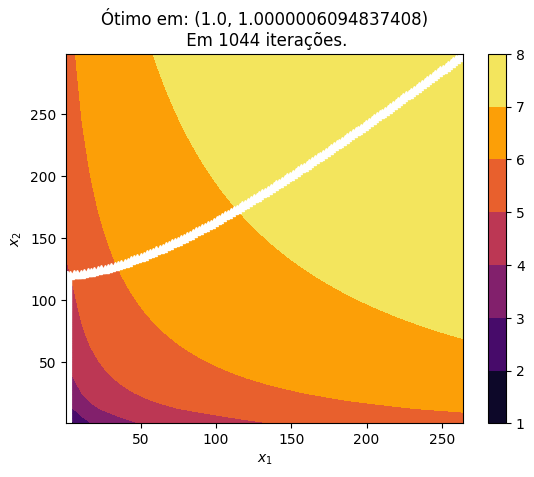

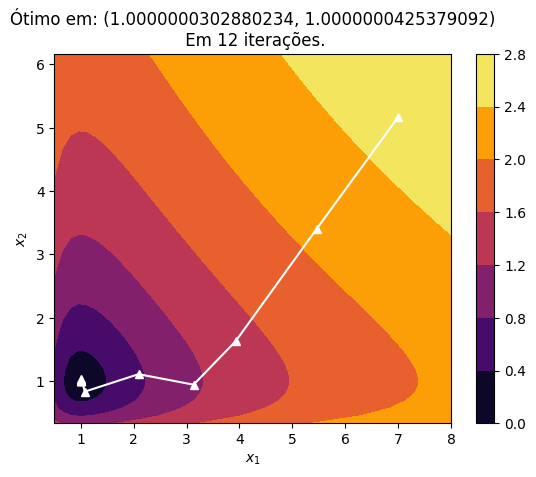

In [27]:
gradientPoints = simulate([canto,parede1,parede2,planalto,randomPoint],gradientMethod,"TABELA 1\n\nMÉTODO GRADIENTE")

for simulation in gradientPoints:
    plotPath(simulation)


#### Newton


 TABELA 2

MÉTODO DE NEWTON 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0102 │   0.0345 │           15 │             32 │ 1.000000 │ 1.000024 │ 0.000024 │           7.55343e-09 │
│  34.0000 │   0.0116 │          317 │            332 │ 1.000000 │ 1.000000 │ 0.000000 │           2.88658e-15 │
│   0.0152 │  97.0000 │          890 │            905 │ 1.000000 │ 1.000000 │ 0.000000 │           0           │
│ 263.0000 │ 298.0000 │          357 │            374 │ 1.000092 │ 0.999999 │ 0.000092 │           3.55797e-07 │
│   7.0000 │   5.1667 │           15 │             32 │ 1.000042 │ 1.000560 │ 0.000561 │           5.55835e-07 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════

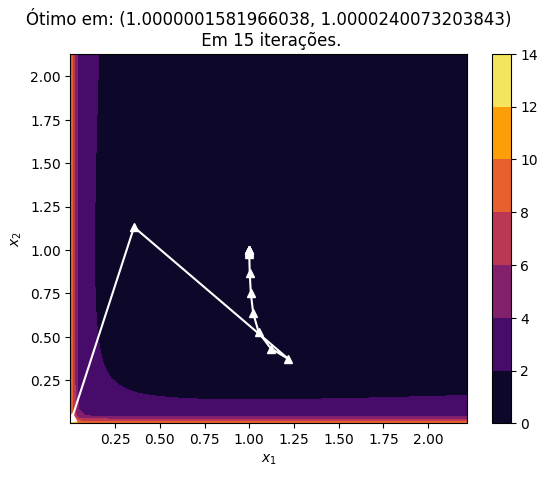

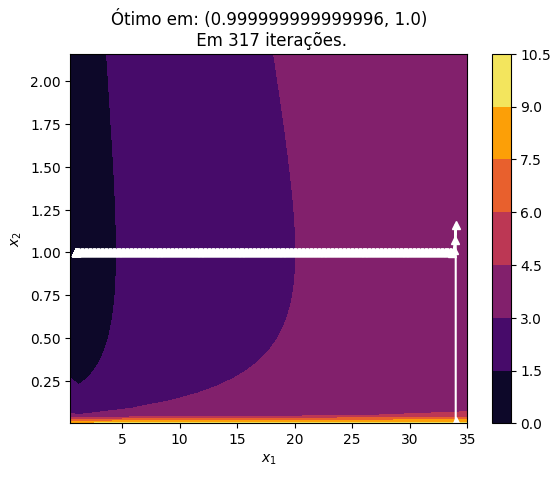

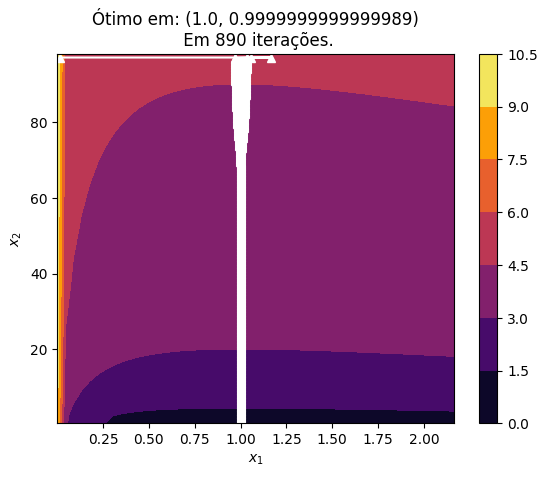

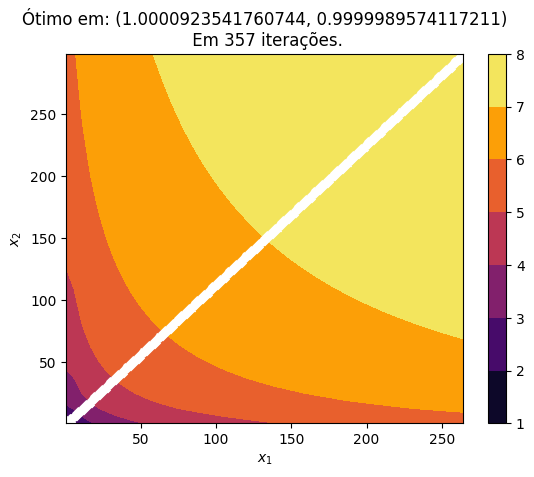

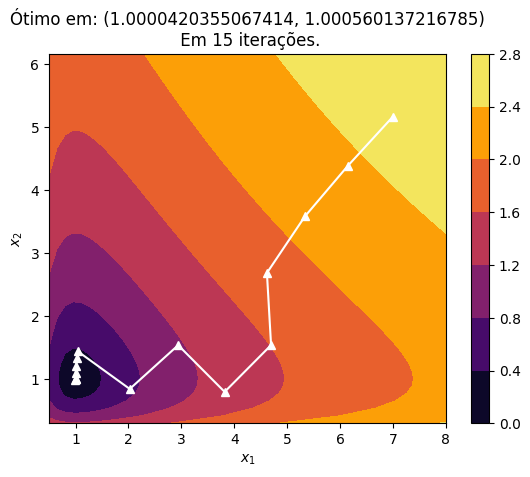

In [28]:
newtonPoints = simulate([canto,parede1,parede2,planalto,randomPoint],newtonMethod,"TABELA 2\n\nMÉTODO DE NEWTON")

for simulation in newtonPoints:
    plotPath(simulation)


#### Quasi Newton


 TABELA 3

MÉTODO BFGS 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0102 │   0.0345 │           31 │             46 │ 1.000000 │ 1.000000 │ 0.000000 │           3.74525e-15 │
│  34.0000 │   0.0116 │          317 │            332 │ 1.000000 │ 1.000000 │ 0.000000 │           2.88658e-15 │
│   0.0152 │  97.0000 │          890 │            905 │ 1.000000 │ 1.000000 │ 0.000000 │           0           │
│ 263.0000 │ 298.0000 │         1443 │           1458 │ 1.000000 │ 1.000000 │ 0.000000 │           1.55431e-15 │
│   7.0000 │   5.1667 │           36 │             51 │ 1.000000 │ 1.000000 │ 0.000000 │           2.40178e-15 │
╘══════════╧══════════╧══════════════╧════════════════╧══════════╧════

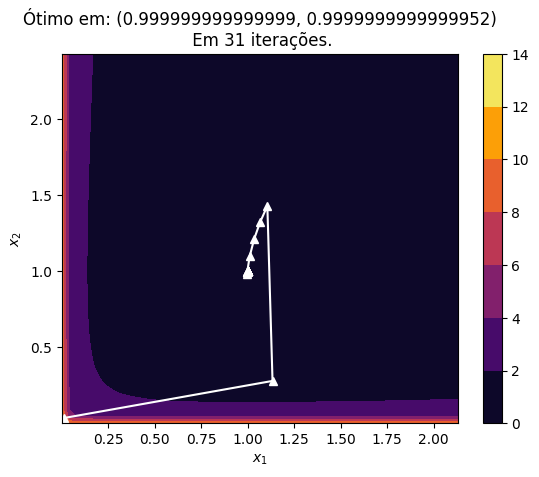

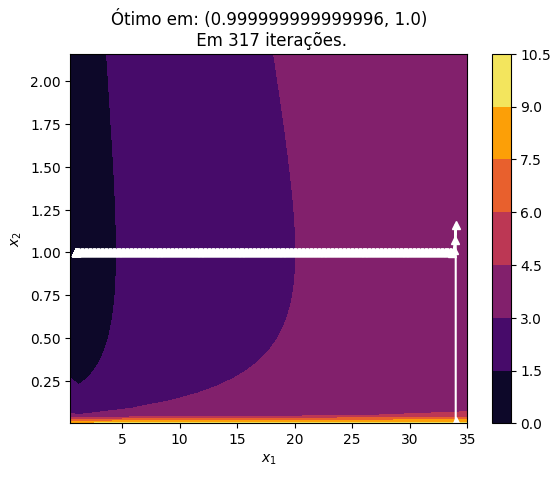

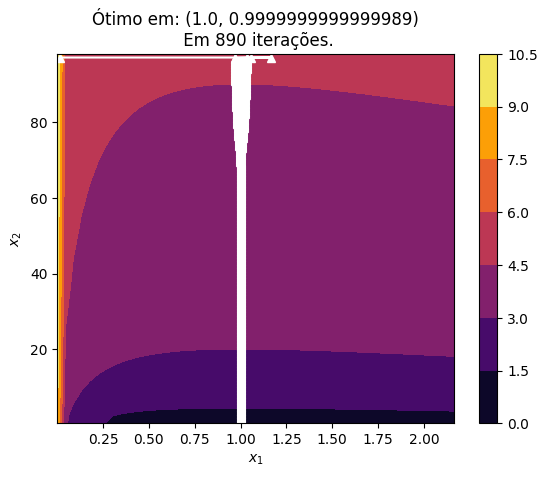

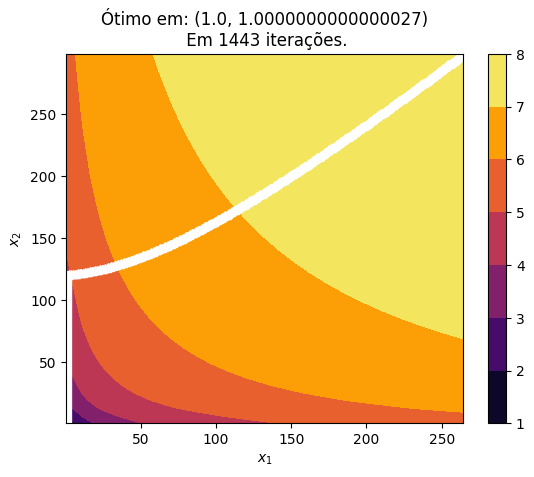

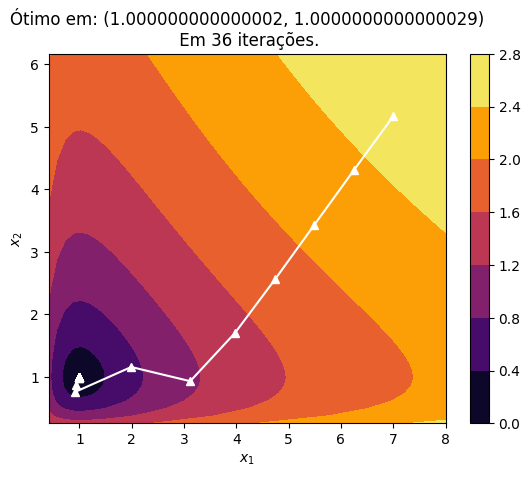

In [29]:
quasiNewtonPoints = simulate([canto,parede1,parede2,planalto,randomPoint],quasiNewtonMethod,"TABELA 3\n\nMÉTODO BFGS")

for simulation in quasiNewtonPoints:
    plotPath(simulation)


#### 4 Direções


 TABELA 4

MÉTODO DAS 4 DIREÇÕES 

╒══════════╤══════════╤══════════════╤════════════════╤══════════╤══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │   X*(x1) │   X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪══════════╪══════════╪══════════╪═══════════════════════╡
│   0.0102 │   0.0345 │            8 │            386 │ 1.000000 │ 1.000000 │ 0.000000 │           2.14928e-07 │
│  34.0000 │   0.0116 │           30 │           2295 │ 1.000000 │ 1.000000 │ 0.000000 │           1.01391e-07 │
│   0.0152 │  97.0000 │           78 │           5839 │ 1.000000 │ 1.000000 │ 0.000000 │           4.87802e-08 │
│ 263.0000 │ 298.0000 │          233 │          16961 │ 1.000000 │ 1.000000 │ 0.000000 │           1.08838e-07 │
│   7.0000 │   5.1667 │           11 │            669 │ 1.000000 │ 1.000000 │ 0.000000 │           2.02334e-08 │
╘══════════╧══════════╧══════════════╧════════════════╧═════

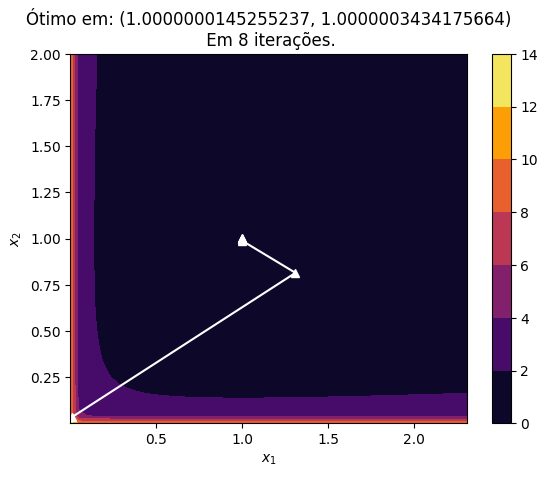

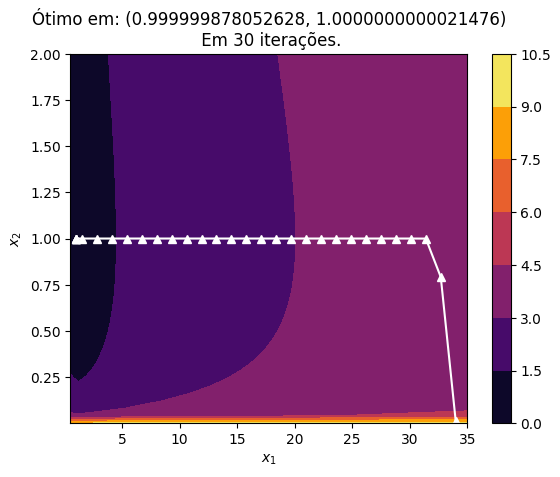

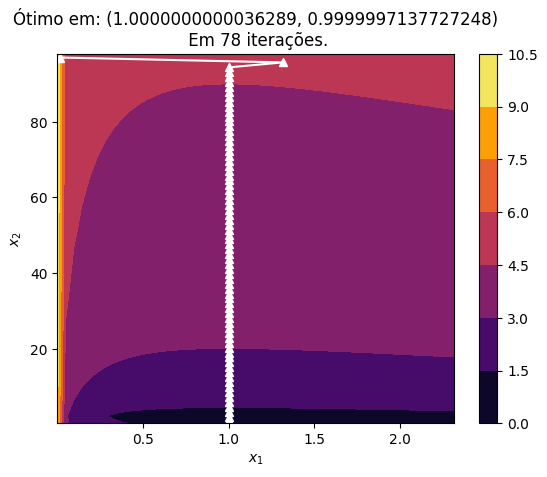

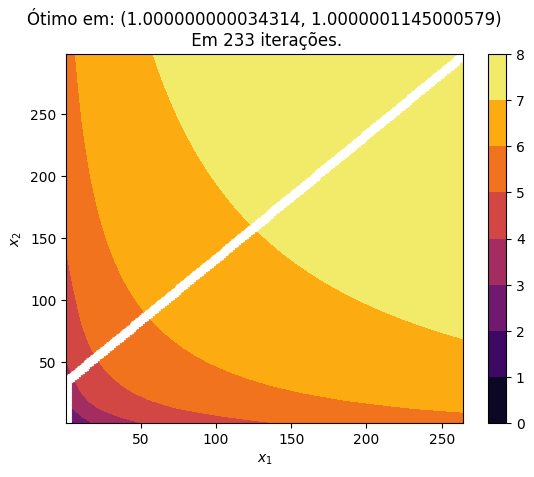

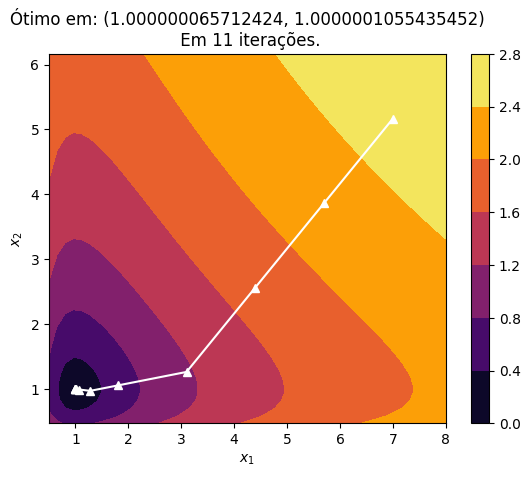

In [30]:
mockPoints = simulate([canto,parede1,parede2,planalto,randomPoint],mockMethod2,"TABELA 4\n\nMÉTODO DAS 4 DIREÇÕES")

for simulation in mockPoints:
    plotPath(simulation)

### 4.2 - Problemas de Convergência do Método de Newton e BFGS

Dado anteriormente que os métodos de newton e quase-newton produzem direções ruins para a regra de armijo, estes precisaram ser ajustados para as simulações anteriores, mas seguem as simulações para os mesmos pontos com os métodos sem ajustes

#### Newton Problemático


 TABELA 5

MÉTODO DE NEWTON SEM AJUSTES 

╒══════════╤══════════╤══════════════╤════════════════╤═══════════╤═══════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │    X*(x1) │    X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪═══════════╪═══════════╪══════════╪═══════════════════════╡
│   0.0102 │   0.0345 │            1 │             19 │  0.010204 │  0.034483 │ 5.688638 │           5.00301e-07 │
│  34.0000 │   0.0116 │           20 │             32 │ 12.150001 │  0.006644 │ 5.601581 │           1.18307e-07 │
│   0.0152 │  97.0000 │           71 │             83 │  0.005295 │ 16.500001 │ 5.943696 │           4.62682e-08 │
│ 263.0000 │ 298.0000 │          356 │            373 │  0.998132 │  0.997790 │ 0.002896 │           5.24805e-07 │
│   7.0000 │   5.1667 │           14 │             31 │  0.982443 │  0.972267 │ 0.033238 │           2.97553e-07 │
╘══════════╧══════════╧══════════════

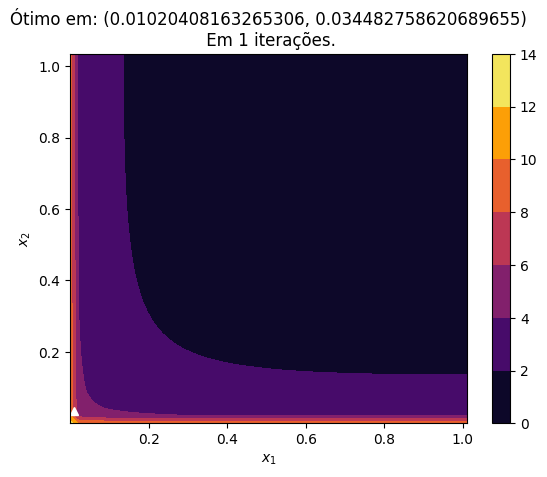

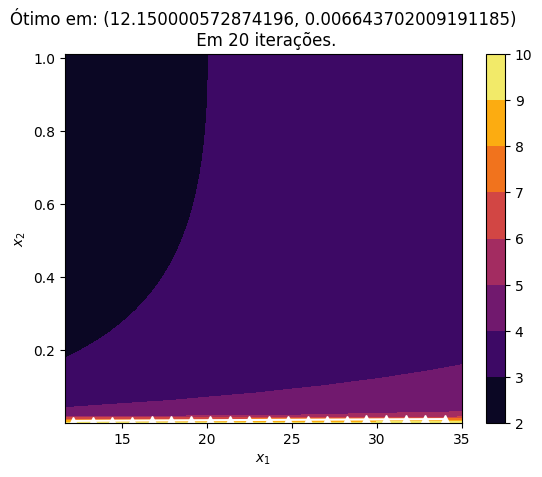

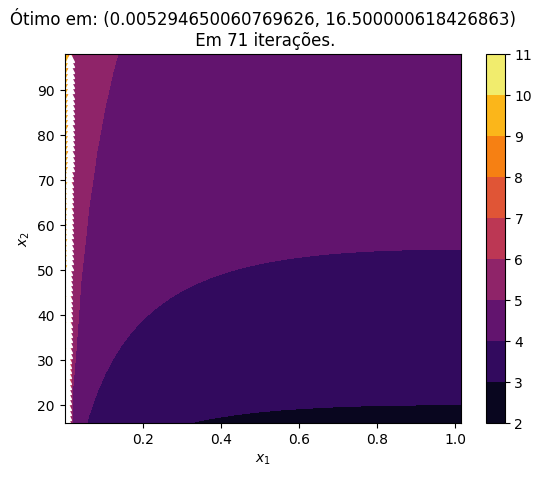

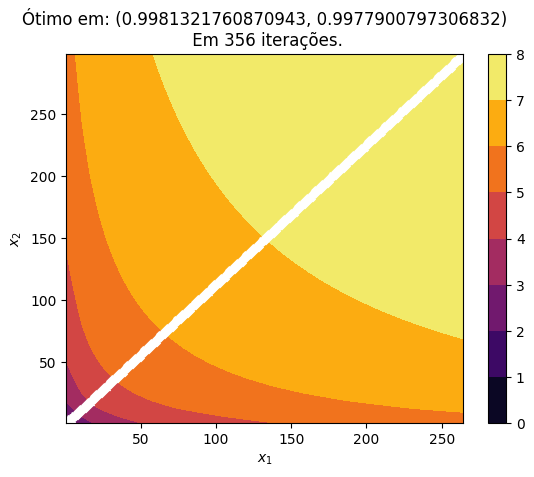

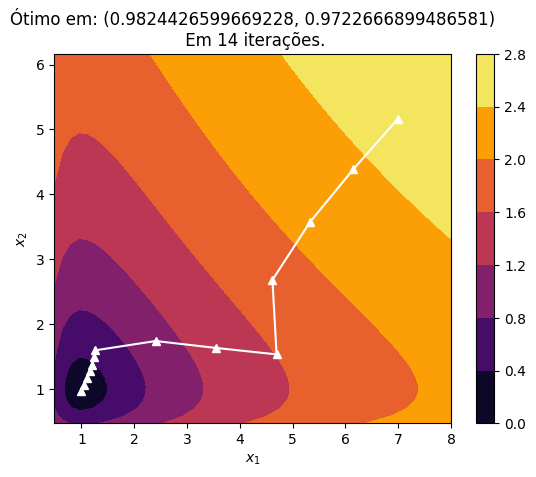

In [31]:
newtonBrokenPoints = simulate([canto,parede1,parede2,planalto,randomPoint],newtonMethodBroken,"TABELA 5\n\nMÉTODO DE NEWTON SEM AJUSTES")

for simulation in newtonBrokenPoints:
    plotPath(simulation)


#### BFGS Problemático

iteration limit
iteration limit

 TABELA 6

MÉTODO BFGS SEM AJUSTES 

╒══════════╤══════════╤══════════════╤════════════════╤════════════╤════════════╤══════════╤═══════════════════════╕
│   X°(x1) │   X°(x2) │   #Iteracoes │   #Cham.Armijo │     X*(x1) │     X*(x2) │    f(X*) │   Erro de Aproximacao │
╞══════════╪══════════╪══════════════╪════════════════╪════════════╪════════════╪══════════╪═══════════════════════╡
│   0.0102 │   0.0345 │           26 │             35 │   1.643309 │   0.788047 │ 0.550872 │           6.98991e-07 │
│  34.0000 │   0.0116 │        10001 │          10009 │  33.747582 │   0.909521 │ 3.520186 │           4.97864e-07 │
│   0.0152 │  97.0000 │        10001 │          10009 │   0.955848 │  96.790501 │ 4.572771 │           8.18982e-07 │
│ 263.0000 │ 298.0000 │            2 │             16 │ 262.146205 │ 297.229588 │ 7.964926 │           8.29695e-07 │
│   7.0000 │   5.1667 │            2 │             18 │   6.242923 │   4.301025 │ 2.341464 │           7.5116e-

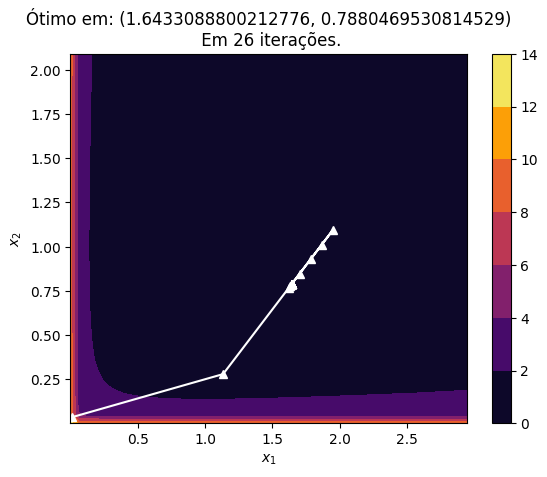

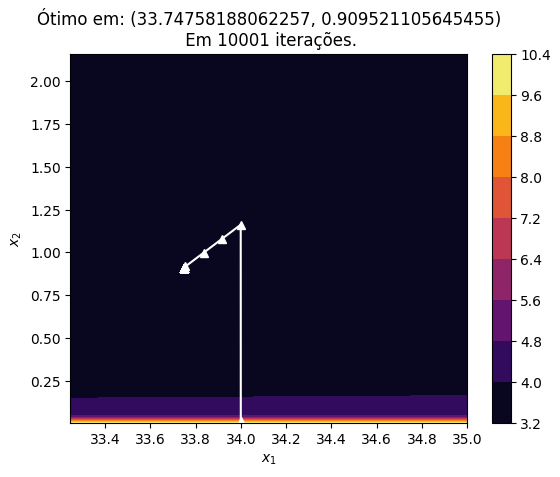

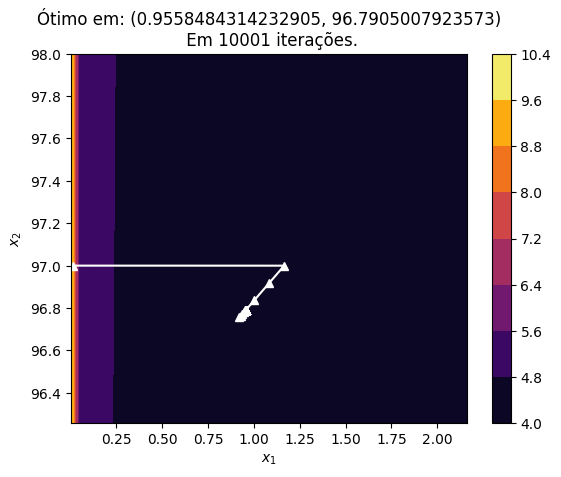

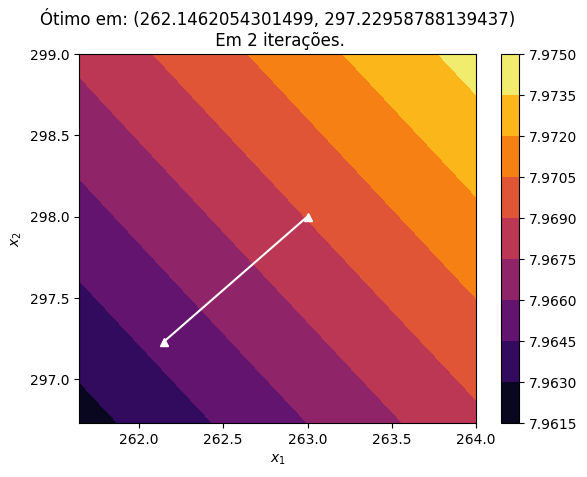

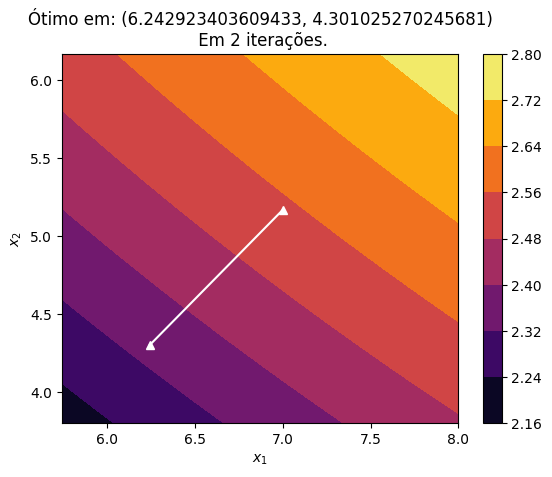

In [32]:
quasiNewtonBrokenPoints = simulate([canto,parede1,parede2,planalto,randomPoint],quasiNewtonMethodBroken,"TABELA 6\n\nMÉTODO BFGS SEM AJUSTES")

for simulation in quasiNewtonBrokenPoints:
    plotPath(simulation)

## 5 - Otimização dos Parâmetros S, $\beta$ e $\sigma$